# 1.Workflows and Agents
- 本文档会帮助了解最常见的几种代理，以及如何在LangGraph中去搭建。
- 一般代理系统可以被分为工作流（workflows）和代理（agents）。
    - 工作流 指的是通过代码预先编排的逻辑流程，由大模型和各类工具协同执行，按照固定路径完成任务。
    - 代理 则是指大模型自主分析和决策，通过调用工具并根据结果实时调整执行方式，以灵活达成目标。

- 图片理解：
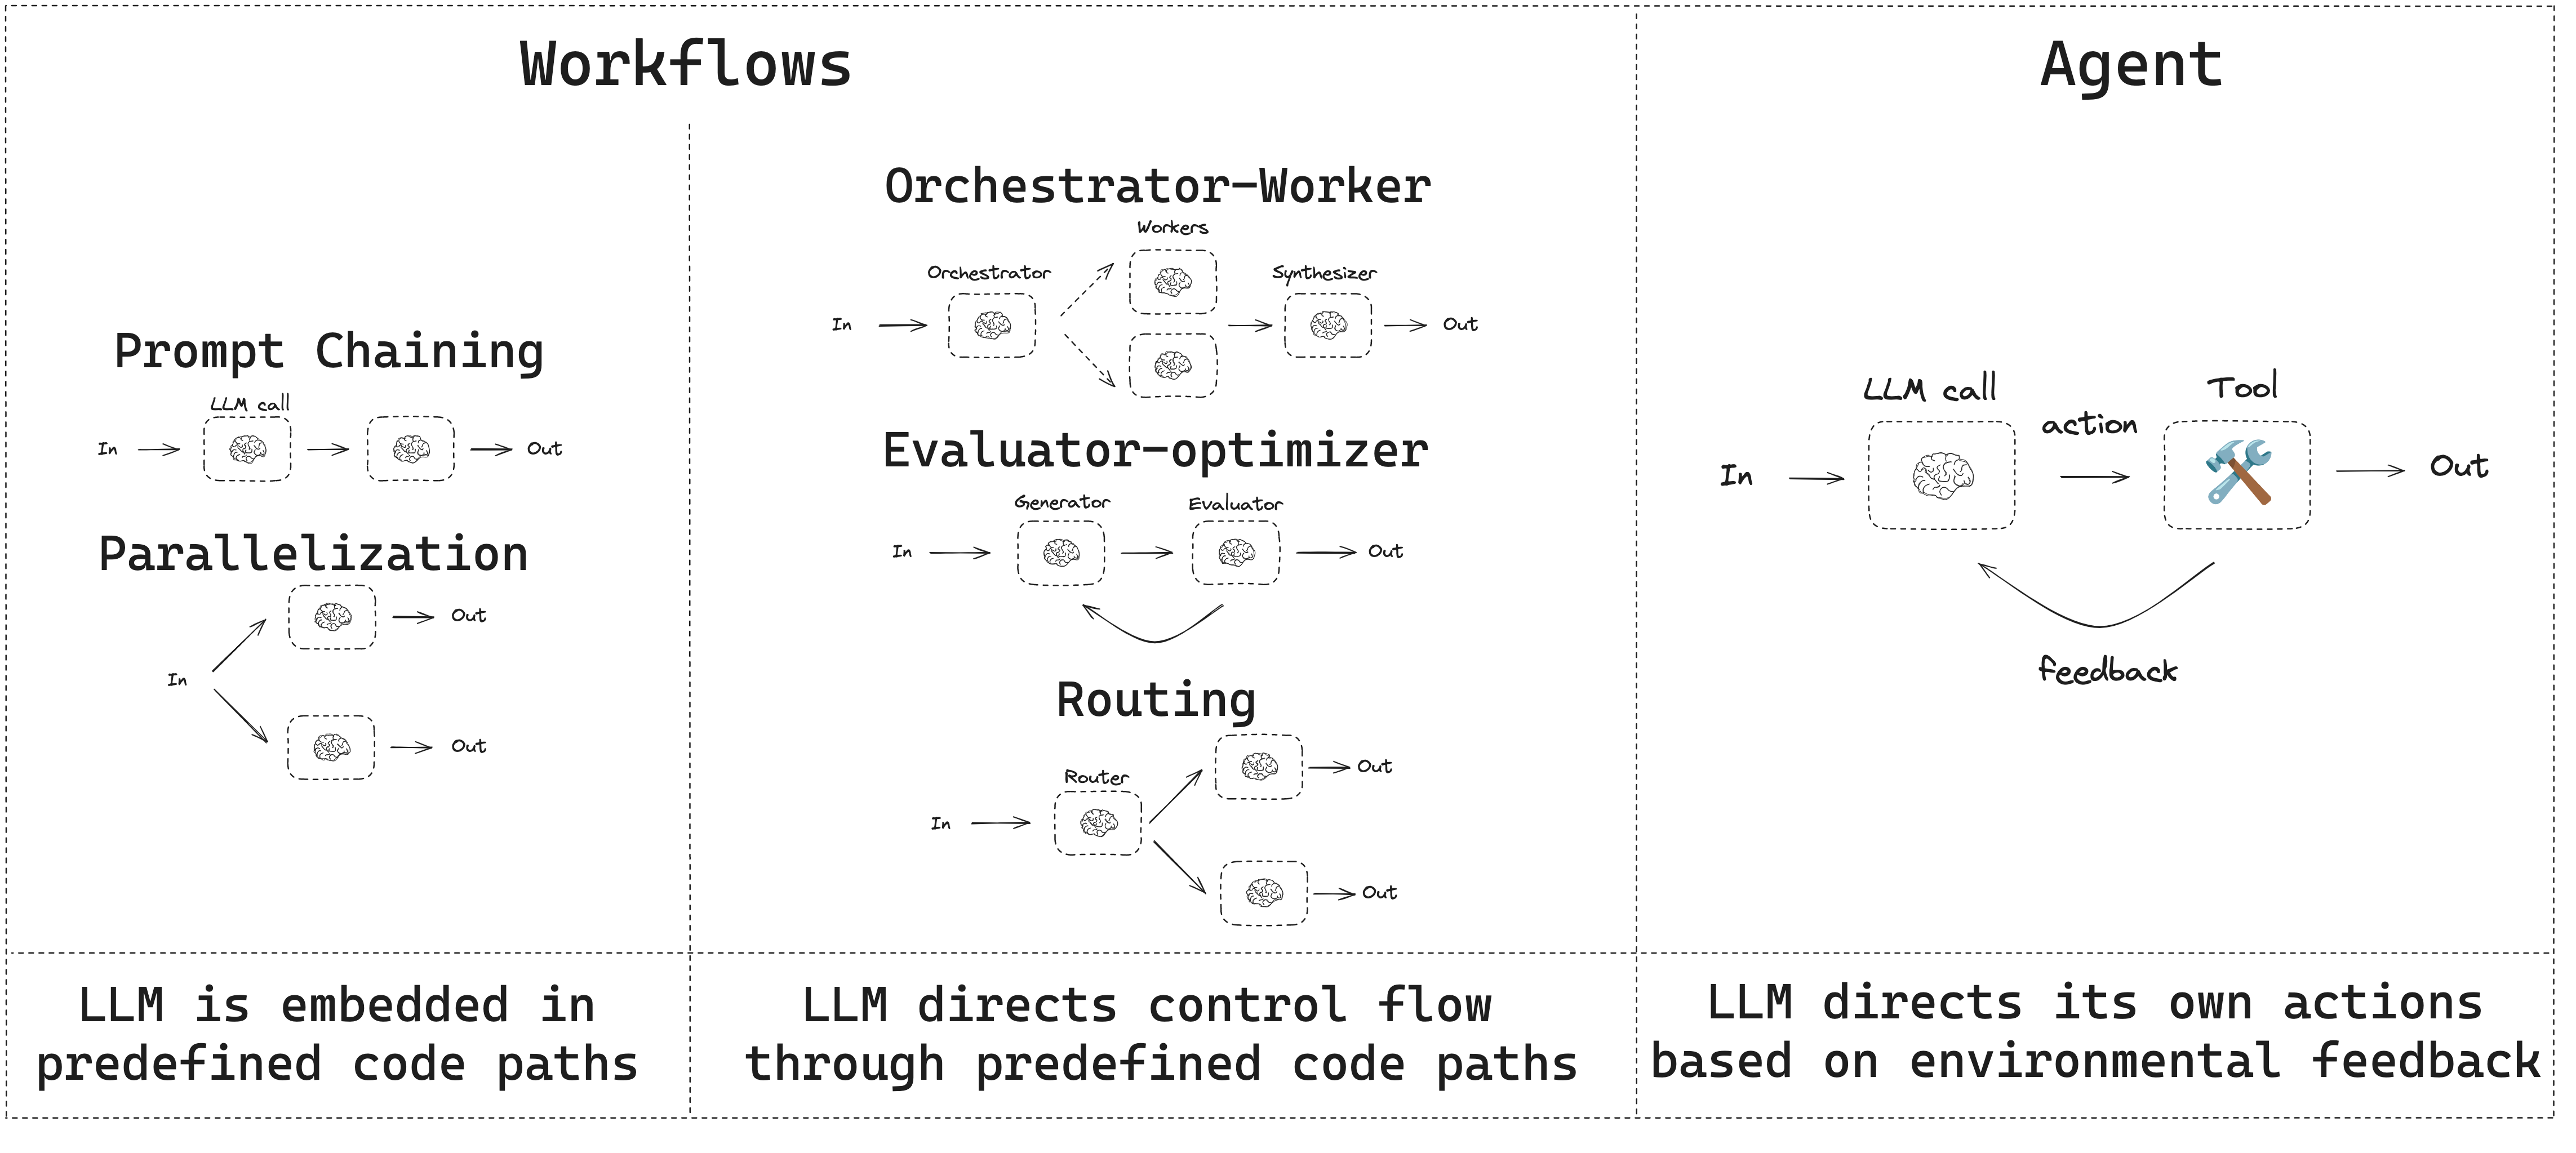
https://langchain-ai.github.io/langgraph/concepts/img/agent_workflow.png

# 2.Set up
- 以下代码为设置DeepSeek API
    - 需要先去官网注册账号并配置密钥，运行一下代码输入密钥即可使用了

In [12]:
from langchain_deepseek import ChatDeepSeek
import os
import getpass

if not os.getenv("DEEPSEEK_API_KEY"):
    os.environ["DEEPSEEK_API_KEY"] = getpass.getpass("Enter your DeepSeek API key: ")

llm = ChatDeepSeek(
    model="deepseek-chat", # 指定使用的模型
    temperature=0, # 控制生成文本的随机性
    max_tokens=8000, # 生成的最大token数限制
    timeout=None, # 请求超时时间
    max_retries=2, # 请求失败时的最大重试次数
    # other params...
)

# 3.Building Blocks: The Augmented LLM
- 构建增强大语言模型模块
- 图片及地址：
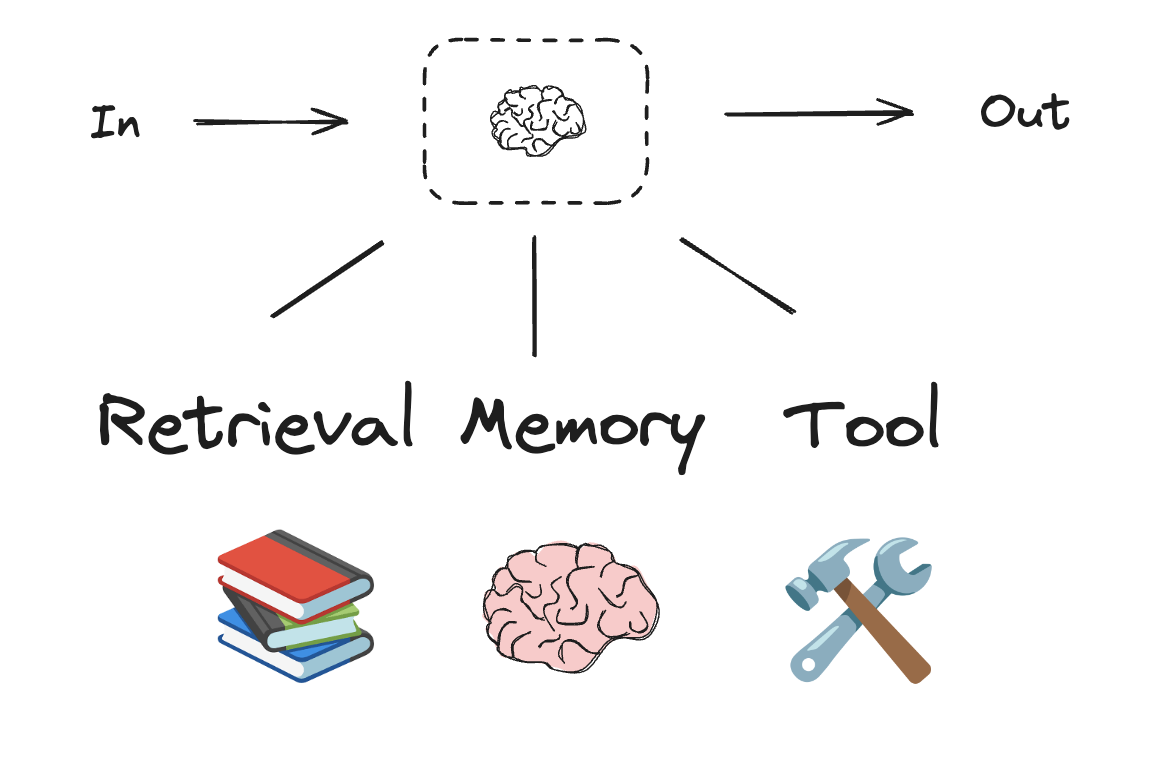
https://langchain-ai.github.io/langgraph/tutorials/workflows/img/augmented_llm.png

## 代码逻辑
- 代码思路整理
    - 代码片段1
```python
class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(
        None, description="Why this query is relevant to the user's request."
    )
structured_llm = llm.with_structured_output(SearchQuery)
```
>       1. SearchQuery定义了一个类，继承了BaseModel的特性，包含两个数据类型。这个类定义了结构化的输出模版，规定了语言模型的输出格式。
        2. BaseModel特性 ： BaseModel 允许你定义带有类型注解的字段（例如 str, int, List 等），并在实例化时自动验证输入数据是否符合这些类型。如果数据类型不匹配，会抛出 ValidationError。
        3. Field特性 ： 使用 Field 函数可以为字段设置默认值（例如 None），或者标记字段为可选。
        4. with_structured_output方法作用 ： 让一个语言模型（LLM）的输出从普通的自然语言文本转换为结构化的数据格式，来源自langchain
        
    - 代码片段2
```python
msg = llm_with_tools.invoke("What is 2 times 3?")
msg.tool_calls
```
> 1. msg.tool_calls 是什么意思？ 语言模型返回的消息内容的属性，包含调用的工具信息



In [3]:
# Schema for structured output
from pydantic import BaseModel, Field

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(
        None, description="Why this query is relevant to the user's request."
    )


# Augment the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

# Invoke the augmented LLM
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")

# Define a tool
def multiply(a: int, b: int) -> int:
    return a * b

# Augment the LLM with tools
llm_with_tools = llm.bind_tools([multiply])

# Invoke the LLM with input that triggers the tool call
msg = llm_with_tools.invoke("What is 2 times 3?")

# Get the tool call
msg.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_0_f0340e41-5b78-405f-b437-e66be60272f5',
  'type': 'tool_call'}]

# 4.Prompt chaining
- 在提示链中，每个大模型都会处理前一个大模型的结果。
    - 但在处理链的过程中，很容易出现失真，所以可以设置Gate来检查修正中间步骤的结果。
    - 图片： 
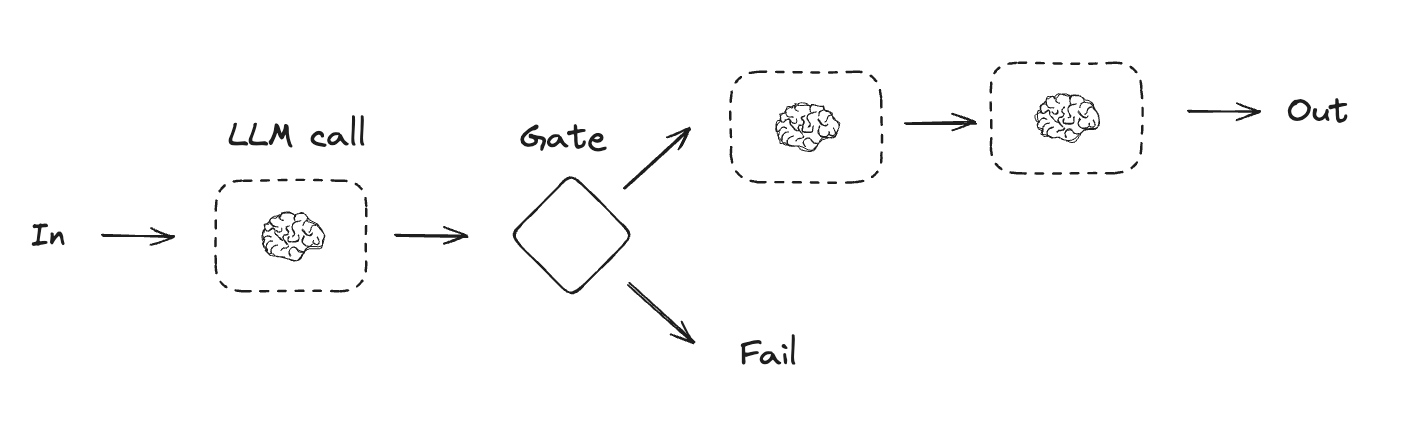
https://langchain-ai.github.io/langgraph/tutorials/workflows/img/prompt_chain.png

## 代码逻辑
    1. 创建状态图StateGraph
    2. 增加节点generate_joke
    3. 增加节点improve_joke
    4. 增加节点polish_joke
    5. 增加边逻辑：
        - START->generate_joke->check_punchline-[Fail]>improve_joke->polish_joke->END
        - START->generate_joke->check_punchline-[Pass]>END
        - 为什么check_punchline=Pass之后直接结束了？如果Fail，那不需要再检查一遍吗？后续的improve和polish都是为了解决punchline？
            - 检查一次，失败就改，改完直接输出
    6. 编译状态图，使其可运行
    7. 状态图可视化
    8. 输入初始State状态，topic=cats，并调用链条
    9. 打印输出

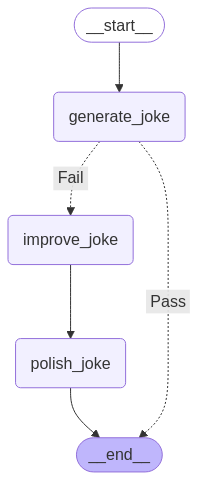

Initial joke:
Sure! Here's a purr-fectly silly one:  

**Why don’t cats play poker in the wild?**  
*Because there are too many cheetahs!* �🎲  

(Or if you prefer a classic: **"Why was the cat sitting on the computer?** *To keep an eye on the mouse!*" 😸)  

Let me know if you want more—I've got a *litter* of them! 😹

--- --- ---

Improved joke:
Here’s a funnier version with extra wordplay and puns:  

**Why don’t cats play poker in the wild?**  
*Because there are too many cheetahs—and they always *lion* about their paws!* 🃏🐾  

*(Bonus groaner: And the ante-lopes keep folding too soon!)* 🦌😂  

Or for the classic:  
**Why was the cat sitting on the computer?**  
*To keep an

--- --- ---

Final joke:
**eye on the mouse!** 🖱️🐱  

*(Surprising twist: But then the dog *byte* him—turns out it was a *firewall*!)* 🔥🐶💻  

*(Bonus groaner: Now he’s stuck in the *cache* and can’t *Ctrl+Alt+Delete*!)* 😹⌨️  

*(Extra twist: The dog? A *malware*-inois!)* 🦮


In [7]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str


# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}


def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Fail"
    return "Pass"


def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}


def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}


# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Fail": "improve_joke", "Pass": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

# Invoke
state = chain.invoke({"topic": "cats"})
print("Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Joke failed quality gate - no punchline detected!")

# 5.Parallelization
- 并行化能让大模型同时处理一个任务
    - 大模型有时能够处理同一个人物，并且将它们的结果程序化的合并成一个。这个工作流，并行化，展示了两个变量。分块化：将一个任务分化成几个独立的子任务并行执行。投票：讲一个任务多执行几次并得到多样化的结果。
    - 什么时候使用并行化的工作流？当分开的子任务能够被并行处理的时候，并行化处理是很高效的，要么就是需要多视角多尝试来获得更好的结果。对于需要多次思考的复杂任务，当一个问题只调用一次大模型时，最终的处理结果会比调用一次处理所有问题要好很多，这样就能让每次调用只关注一个问题。
    - 图片
    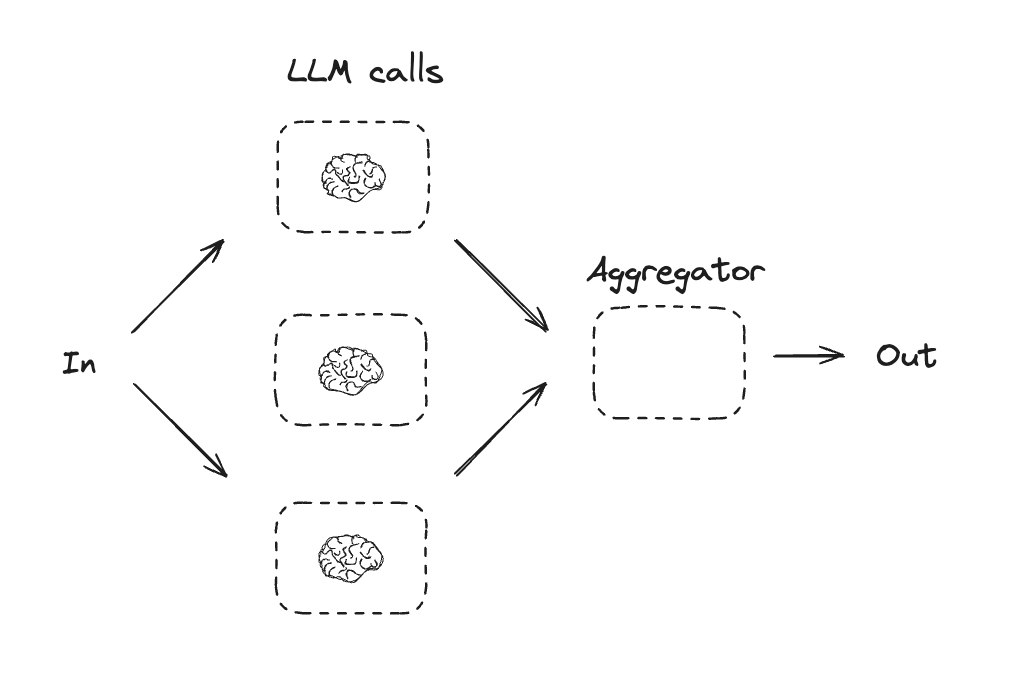
    - https://langchain-ai.github.io/langgraph/tutorials/workflows/img/parallelization.png

## 代码逻辑
1. 创建状态图StateGraph方法
2. 为状态图添加节点-写个笑话
3. 为状态图添加节点-写个故事
4. 为状态图添加节点-写首诗
5. 为状态图添加节点-合并前三个节点的结果
6. 添加流转逻辑：
    1. START, "call_llm_1"
    2. START, "call_llm_2"
    3. START, "call_llm_3"
    4. "call_llm_1", "aggregator"
    5. "call_llm_2", "aggregator"
    6. "call_llm_3", "aggregator"
    7. "aggregator", END
7. 可视化状态图
8. 输入提示词，调用状态图，执行预设好的逻辑
9. 打印最终的结果，state的最终状态

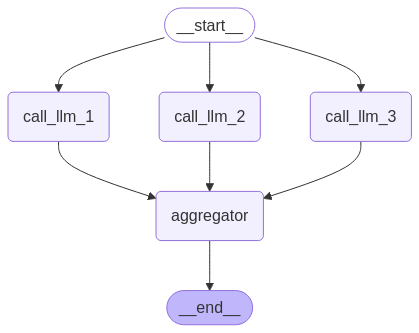

Here's a story, joke, and poem about cats!

STORY:
**The Secret Guardians of Moonlight Alley**  

In the quiet, cobblestone streets of Moonlight Alley, where the gas lamps flickered like fireflies, a secret society of cats ruled the night. To humans, they were just strays—fluffy shadows darting between bins and curling up on windowsills. But beneath their ordinary appearance, these cats were guardians, sworn to protect the alley from unseen dangers.  

Their leader was **Whiskerion**, a massive Maine Coon

JOKE:
Sure! Here's a purr-fect cat joke for you:  

**Why don’t cats play poker in the wild?**  
*Because there are too many cheetahs!* �🐆  

(Get it? "Cheetahs" sounds like "cheaters"!) 😹  

Want another one? Let me know!

POEM:
**Whiskers and Grace**  

Soft paws tread on silent feet,  
A shadow dance, so light, so sweet.  
Eyes like embers, bright and wise,  
Gleaming gold beneath moonlit skies.  

Purring hums, a lullaby,  
Warm as sun, as days drift by.  
Tail aloft, a flag so p

In [8]:
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str


# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def call_llm_2(state: State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}


def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}


def aggregator(state: State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}


# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = parallel_workflow.invoke({"topic": "cats"})
print(state["combined_output"])

# 6.Routing
- 路由是指将一个输入进行分类并划分成几个任务。这个工作流对任务的分割很擅长，并能够建立特殊的提示词。没有这个工作流，在优化某一类任务时会导致其他类型的任务效率降低。
- 什么时候使用这个工作流？ 路由对于有明确分类的复杂任务比较友好，这类任务通常更容易被分割处理，并且大模型或者传统分类方法都能够很精确的处理分类需求。
- 图片：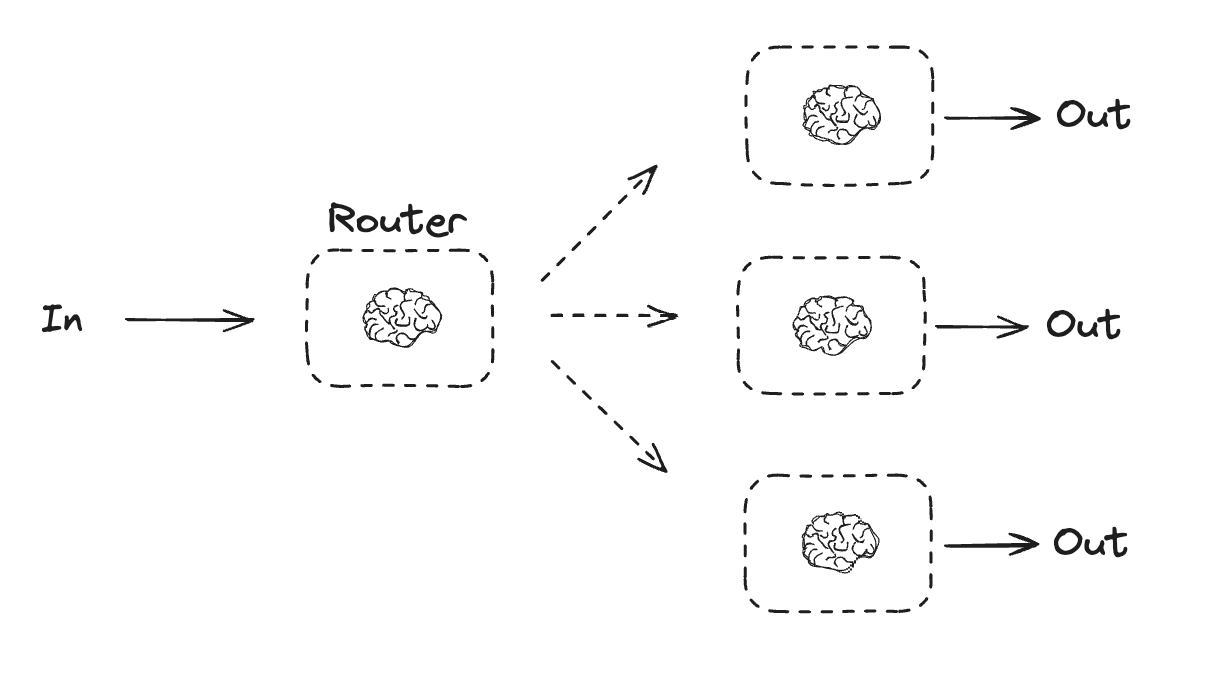
https://langchain-ai.github.io/langgraph/tutorials/workflows/img/routing.png

## 代码逻辑
- with_structured_output 定义好路由节点的输出格式
    - step: Literal：step 字段的值 只能是这三种字符串之一："poem"、"story"、或 "joke"。

- 创建状态图 StateGraph
- 创建并添加节点-写一个故事
- 创建并添加节点-写一个笑话
- 创建并添加节点-写一首诗
- 创建并添加节点-任务路由节点-llm_call_router
    1. 调用定义好输出格式的大模型，接收提示词并让大模型对输入的提示词进行分类，是故事、笑话还是诗
    2. 返回分类结果，将结果值赋值给State的Decision键，这样Decision就有
- 添加执行逻辑
    - START, "llm_call_router"：输出decision的结果值
    - "llm_call_router",     route_decision,
        - route_decision : 判断decision的值是什么，根据判断结果选择下一个节点
    - "llm_call_1", END
    - "llm_call_2", END
    - "llm_call_3", END
- 编译状态图
- 可视化状态图
- 输入提示词进行状态图的调用
- 处理逻辑是：提示词输入以后，大模型判断要写什么类型，然后输出值并更新State，这个节点完成后，开始条件判断，判断输出的类型是写什么，就跟据条件边的判定结果执行对应的节点即可。

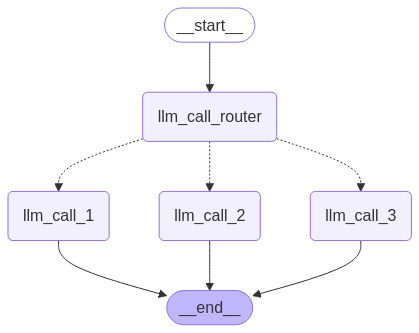

Sure! Here's a purr-fect cat joke for you:  

**Why don’t cats play poker in the wild?**  
*Because there are too many cheetahs!*  

🐱😆 Let me know if you want another one!


In [9]:
from typing_extensions import Literal
from langchain_core.messages import HumanMessage, SystemMessage


# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )


# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)


# State
class State(TypedDict):
    input: str
    decision: str
    output: str


# Nodes
def llm_call_1(state: State):
    """Write a story"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_2(state: State):
    """Write a joke"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_3(state: State):
    """Write a poem"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}


# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"


# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = router_workflow.invoke({"input": "Write me a joke about cats"})
print(state["output"])

# 7.Orchestrator-Worker
- 调度-协调工作流指的是，一个大模型调度员将任务划分成几块，然后将子任务给到大模型执行员。
- 当无法预测一个问题的分类结果是什么的时候，可以使用这个工作流。比如在代码任务中，需要修改的文件数量和每个文件需要修改的属性依赖于原始任务的具体情况。这种任务逻辑上是相似的，与并行化的关键不同是这种工作流更具备灵活性，子任务模式没办法被预编辑，取决于调度员对具体任务的分析
- 图片：
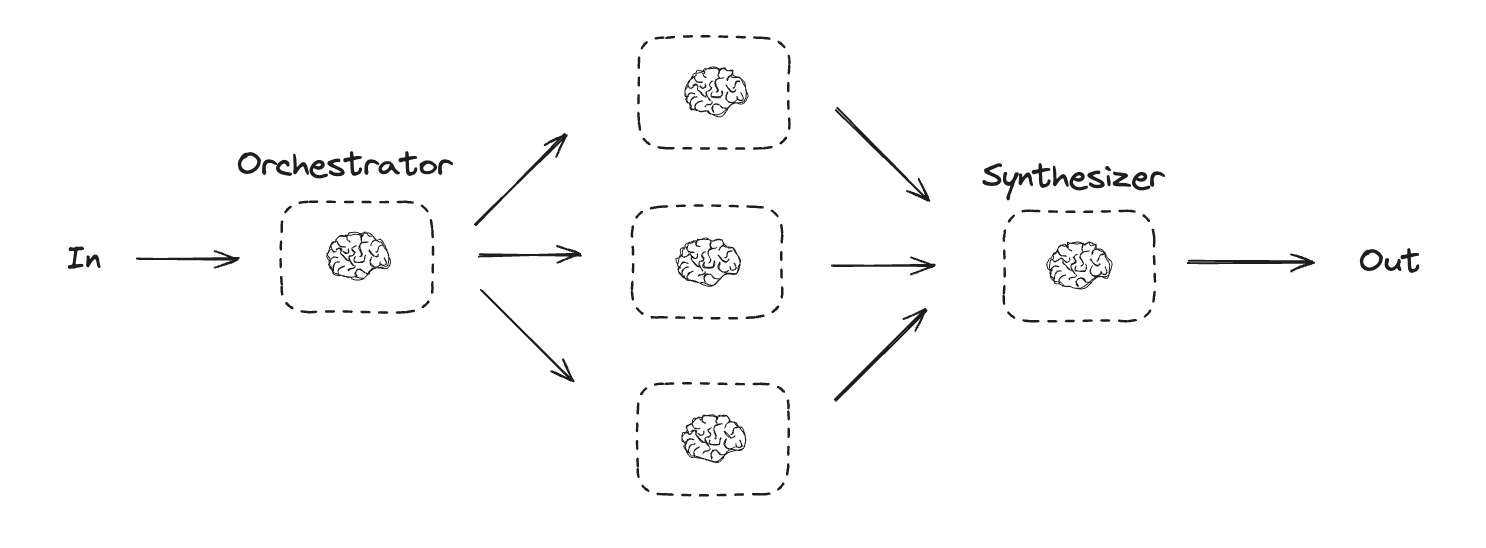
https://langchain-ai.github.io/langgraph/tutorials/workflows/img/worker.png

## 代码逻辑
1. 输入提示词并调用orchestrator_worker工作流实例：Create a report on LLM scaling laws
    - [State]：topic改变，sections没有改变，completed_sections没有改变，final_report没有改变
    - [WorkerState]： 没有变化
    - 调用状态图的第一步是修改State状态，后续节点会需要调用这个状态，里面会存储输入的提示词
    - orchestrator_worker是编译好的工作流实例
2. 开始执行第一个节点:START -> "orchestrator";
    - [State]：topic改变，sections变为大语言模型结果，completed_sections没有改变，final_report没有改变
    - [WorkerState]： 没有变化
    1. orchestrator 节点： 拿到状态中的提示词，定义提示词模版，将提示词嵌入一起给到大模型。这里大模型为第一步规定好输出的大模型planner，当给到提示词之后，结果会按照sections格式进行输出。最后将输出结果更新到state的sections部分，完成这个节点的作用，生成一个plan。
3. 流转逻辑判断 :"orchestrator" -> assign_workers ^ ["llm_call"];
    - [State]：没有变化，这里仅仅使用的sections的内容进行任务拆解和分发
    - [WorkerState]： 没有变化。
    3. assign_workers：条件逻辑，在什么条件下从orchestrator节点流转到llm_call节点。条件函数返回一个send对象列表，就知道要多线执行列表中的任务。函数已通过循环将不同的section分发到了不同的send对象上。
        - Send 是 LangGraph 中的一个特殊工具（来自 langgraph.constants），用于在工作流中实现动态任务分发，特别是并行任务的调度。它的作用是告诉系统：“把这个任务发给某个节点去执行，并且可以并行处理多个任务”。Send(target（发送节点名称）, value（发送什么内容）)。
    4. "llm_call"：节点名称映射
4. 开始执行第二个节点："llm_call" -> "synthesizer";           
    - [State]：completed_sections改变，多个节点的执行结果叠加，结果状态的叠加操作由langgraph后台进行，return中的completed_sections是新的字典的键。
    - [WorkerState]： 不变
    - 逻辑： 调用无结构化输出结果的大模型，定义好模版，在接收到上一步send对象传输过来的[state]的单个章节信息后，要求大模型根据提供的name和decription写一篇报告。最终将结果更新到WorkState的completed_sections的属性上去。
5. 开始执行第三个节点："synthesizer" -> END;       
    - [State]：final_report被更新为新的状态
    - [WorkerState]：
    - 逻辑 ： 拿到每个章节总结的列表，将章节按顺序连接起来，更新到final_report上。
6. 打印出来结果：
    - Markdown(state["final_report"])
    
问题：
1. 为什么State是全局变量？
    - 在构建工作流时，StateGraph(State) 用 State 定义了整个图的状态结构：orchestrator_worker_builder = StateGraph(State)
    - WorkerState 是局部状态：



In [13]:
from typing import Annotated, List
import operator


# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

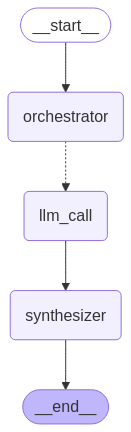

# Overview of LLM Scaling Laws  

Large Language Models (LLMs) have demonstrated remarkable capabilities in natural language processing, reasoning, and generation. A key factor behind their success is the empirical observation of **scaling laws**, which describe predictable improvements in model performance as key computational factors—such as model size, dataset size, and training compute—are increased. These laws provide a framework for understanding how performance scales with resources, enabling more efficient model development and deployment.  

Scaling laws are significant in artificial intelligence for several reasons:  
- **Predictability**: They allow researchers to estimate the performance of larger models before training, reducing trial-and-error experimentation.  
- **Resource Optimization**: By identifying optimal scaling strategies, organizations can allocate compute budgets more effectively.  
- **Benchmarking Progress**: Scaling trends help assess whether improvements stem from architectural innovations or simply increased scale.  

This report examines the foundational principles of LLM scaling laws, their mathematical formulations, and practical implications for AI research and industry applications. Additionally, it explores emerging challenges and future directions in scaling, including efficiency trade-offs and the limits of current paradigms.

---

# Background and Description  

## Large Language Models (LLMs)  
Large Language Models (LLMs) are a class of artificial intelligence models designed to process and generate human-like text. These models are trained on vast datasets using deep learning techniques, typically leveraging transformer architectures (Vaswani et al., 2017). LLMs excel in tasks such as text completion, translation, summarization, and question answering by predicting the next token in a sequence based on contextual understanding.  

Key characteristics of LLMs include:  
- **Scale**: They contain billions (or even trillions) of parameters, enabling them to capture complex linguistic patterns.  
- **Generalization**: Pre-trained on diverse corpora, they exhibit strong zero-shot and few-shot learning capabilities.  
- **Fine-tuning**: Can be adapted to specialized tasks through additional training on domain-specific data.  

## Scaling Laws  
Scaling laws describe the relationship between model performance and computational resources, dataset size, and model size. Empirical studies (Kaplan et al., 2020) have shown that increasing these factors leads to predictable improvements in model capabilities. Key observations include:  
- **Power-law scaling**: Performance improves as a power function of compute, data, or parameters.  
- **Diminishing returns**: Beyond a certain threshold, further scaling yields smaller relative gains.  
- **Emergent abilities**: Some capabilities (e.g., reasoning, in-context learning) appear only at larger scales.  

## Historical Development  
The evolution of LLMs has been marked by several milestones:  
1. **Early NLP Models**: Rule-based systems and statistical models (e.g., n-grams) dominated before the deep learning era.  
2. **Neural Language Models**: Recurrent Neural Networks (RNNs) and Long Short-Term Memory (LSTM) networks improved sequential text modeling.  
3. **Transformer Revolution**: The introduction of the transformer architecture (2017) enabled parallel processing and attention mechanisms, leading to models like GPT (Generative Pre-trained Transformer).  
4. **Modern LLMs**: Models such as GPT-3 (2020), PaLM (2022), and GPT-4 (2023) pushed the boundaries of scale and performance, demonstrating unprecedented language understanding and generation.  

This progression highlights the interplay between algorithmic innovation, hardware advancements, and empirical scaling insights.

---

# Key Principles of LLM Scaling Laws  

The scaling laws governing Large Language Models (LLMs) are derived from empirical observations and theoretical foundations that describe how model performance improves with increases in compute, data, and model size. These principles provide a framework for optimizing LLM development and deployment.  

## Empirical Observations  

1. **Power-Law Scaling**: Performance (measured by metrics like perplexity or downstream task accuracy) follows a power-law relationship with respect to compute, dataset size, and model parameters. This means that improvements in performance are predictable but subject to diminishing returns.  

2. **Compute-Optimal Training**: The Chinchilla scaling law (Hoffmann et al., 2022) demonstrated that for a given compute budget, models should balance parameter count and training tokens. Overparameterization or undertraining leads to suboptimal efficiency.  

3. **Data Efficiency**: Larger models require proportionally more data to avoid overfitting. The optimal dataset size scales with model size, ensuring that models generalize well rather than memorizing training examples.  

## Theoretical Foundations  

1. **Neural Scaling Laws**: These laws emerge from the statistical properties of deep learning, where larger models better approximate the underlying data distribution. The scaling exponent (typically between 0.05 and 0.5) determines how quickly performance improves with increased resources.  

2. **Loss Scaling**: The test loss (L) of a model follows a power-law decay with respect to training compute (C):  
   \[
   L(C) \propto C^{-\alpha}
   \]  
   where \(\alpha\) is a scaling exponent dependent on architecture and data.  

3. **Emergent Capabilities**: Beyond a certain scale, LLMs exhibit emergent behaviors—capabilities not present in smaller models—suggesting phase transitions in performance as model size increases.  

## Practical Implications  

- **Optimal Allocation**: Scaling laws guide resource allocation, helping practitioners decide whether to increase model size, training data, or compute for maximum efficiency.  
- **Predictive Modeling**: These laws enable performance forecasting, allowing teams to estimate the compute needed for target performance levels.  
- **Architecture Choices**: Transformer-based models exhibit consistent scaling behavior, reinforcing their dominance in LLM development.  

Understanding these principles is critical for efficient LLM training, ensuring that scaling efforts yield meaningful improvements without excessive resource expenditure.

---

# Empirical Evidence  

Several studies have empirically validated the scaling laws in Large Language Models (LLMs), demonstrating predictable improvements in performance with increases in model size, compute, and dataset size. Key findings include:  

### **Compute Scaling**  
- **Kaplan et al. (2020)** established that model performance follows a power-law relationship with compute, where performance improves as a function of compute budget (C), model size (N), and dataset size (D).  
- **Chinchilla (Hoffmann et al., 2022)** refined these laws, showing that optimal performance is achieved when model size and training tokens are scaled proportionally (e.g., a 70B parameter model trained on 1.4T tokens).  

### **Model Size vs. Performance**  
- **GPT-3 (Brown et al., 2020)** demonstrated that increasing model size from 125M to 175B parameters led to significant improvements in few-shot and zero-shot learning.  
- **Gopher (Rae et al., 2021)** confirmed that larger models (280B parameters) outperform smaller ones in reasoning and knowledge-intensive tasks.  

### **Dataset Scaling**  
- **The Pile (Gao et al., 2020)** showed that training on diverse, high-quality datasets improves model generalization.  
- **LLaMA (Touvron et al., 2023)** demonstrated that smaller models trained on more tokens (e.g., 7B parameters on 1T tokens) can match or exceed larger models trained on fewer tokens.  

### **Diminishing Returns**  
- Empirical studies suggest that while scaling improves performance, the marginal gains decrease as models grow larger, necessitating more efficient training strategies.  

These findings underscore the importance of balancing model size, compute, and data to optimize LLM performance efficiently.

---

# Challenges and Limitations  

Scaling large language models (LLMs) presents several significant challenges and limitations, spanning technical, economic, and ethical domains.  

### **Computational Costs**  
Training and deploying LLMs require immense computational resources, often necessitating specialized hardware like GPUs or TPUs. The energy consumption associated with training models at scale raises environmental concerns, with some estimates suggesting carbon footprints comparable to long-haul flights. Additionally, the financial cost of infrastructure and maintenance can be prohibitive for smaller organizations, exacerbating disparities in AI accessibility.  

### **Diminishing Returns**  
While increasing model size and training data often improve performance, the relationship is not linear. Beyond a certain threshold, marginal gains in accuracy or capability diminish, requiring exponentially more resources for incremental improvements. This raises questions about the sustainability of scaling as the primary path to advancement in AI.  

### **Ethical Considerations**  
- **Bias and Fairness:** LLMs trained on large, unfiltered datasets may perpetuate or amplify societal biases, leading to harmful outputs.  
- **Misinformation and Abuse:** The ability of LLMs to generate realistic text poses risks, including the spread of misinformation, deepfake content, and malicious automation.  
- **Transparency and Accountability:** The opacity of large-scale models makes it difficult to audit decision-making processes, complicating efforts to ensure fairness and compliance with regulations.  

Addressing these challenges requires a multidisciplinary approach, balancing technical innovation with ethical oversight and sustainable practices.

---

# Future Directions  

The field of LLM scaling laws is rapidly evolving, with several promising avenues for future research and technological advancements. Below are key areas of exploration that could shape the next generation of large language models (LLMs):  

### **1. Beyond Compute-Optimal Scaling**  
Current scaling laws primarily focus on compute-optimal training, but future work may investigate:  
- **Data efficiency**: Developing methods to maximize performance with limited data, reducing reliance on massive datasets.  
- **Dynamic scaling**: Adaptive scaling laws that adjust compute, data, and model size in real-time based on task complexity.  
- **Multi-objective optimization**: Balancing trade-offs between accuracy, inference speed, and energy consumption.  

### **2. Architectural Innovations**  
Emerging model architectures could redefine scaling laws:  
- **Sparse and mixture-of-experts (MoE) models**: Investigating how sparsity impacts scaling efficiency.  
- **Recurrent and hybrid architectures**: Exploring whether recurrent components enable better scaling for long-context tasks.  
- **Neuromorphic and biologically inspired designs**: Potential breakthroughs from non-traditional neural architectures.  

### **3. Energy-Efficient Scaling**  
As environmental concerns grow, future research may prioritize:  
- **Green AI**: Developing scaling laws that minimize carbon footprint while maintaining performance.  
- **Hardware-aware optimization**: Tailoring models to specialized hardware (e.g., neuromorphic chips, quantum computing).  

### **4. Transfer Learning and Generalization**  
Future scaling laws could focus on:  
- **Cross-domain adaptation**: Understanding how scaling affects transferability across tasks and languages.  
- **Few-shot and zero-shot learning**: Improving efficiency in low-resource settings.  

### **5. Ethical and Societal Implications**  
Scaling laws must address:  
- **Bias and fairness**: Ensuring equitable performance across demographics.  
- **Transparency and interpretability**: Developing methods to explain scaling-driven behaviors.  

### **6. Integration with Other AI Paradigms**  
Potential synergies with:  
- **Reinforcement learning (RL)**: Scaling laws for RL-based language models.  
- **Multimodal models**: Extending scaling principles to vision, audio, and other modalities.  

By addressing these challenges, future advancements in LLM scaling laws could unlock unprecedented capabilities while ensuring responsible and sustainable AI development.

---

# Conclusion  

The exploration of LLM scaling laws has yielded several key findings that shape our understanding of large language models and their development. First, empirical evidence supports the power-law relationship between model size, dataset size, and computational resources, demonstrating predictable improvements in performance with increased scale. Second, diminishing returns emerge as models grow, suggesting that efficiency optimizations—such as better architectures, data quality, and training techniques—will become increasingly critical.  

These findings have significant implications for the field. Researchers and practitioners must balance scale with cost-effectiveness, focusing not only on larger models but also on innovations that enhance performance without exponential resource demands. Additionally, the environmental and economic costs of training massive models necessitate a shift toward sustainable scaling strategies.  

Looking ahead, the future of LLM scaling laws will likely involve hybrid approaches that combine scaling with algorithmic breakthroughs, such as sparse models, modular architectures, and improved data utilization. As the field matures, interdisciplinary collaboration will be essential to address ethical, environmental, and accessibility challenges while unlocking the full potential of large language models.

In [14]:
from langgraph.constants import Send


# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report


# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]


# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]


# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})

from IPython.display import Markdown
Markdown(state["final_report"])

# 8.Evaluator-optimizer
- 对于Evaluator-optimizer工作流，由一个大模型生成回复，然后由另外一个大模型进行评估并给到反馈，反复循环直到满足要求。
- 什么场景使用这个工作流更好呢？ 这个工作流程在我们有明确的评估标准，并且迭代优化能提供可衡量的价值时尤为有效。
- 良好适配的两个标志是：首先，当人类明确表达他们的反馈时，LLM 的回应能够得到显著改进；其次，LLM 本身能够提供这样的反馈。这类似于人类作家在创作一份精炼文档时所经历的迭代写作过程。
- 图解： 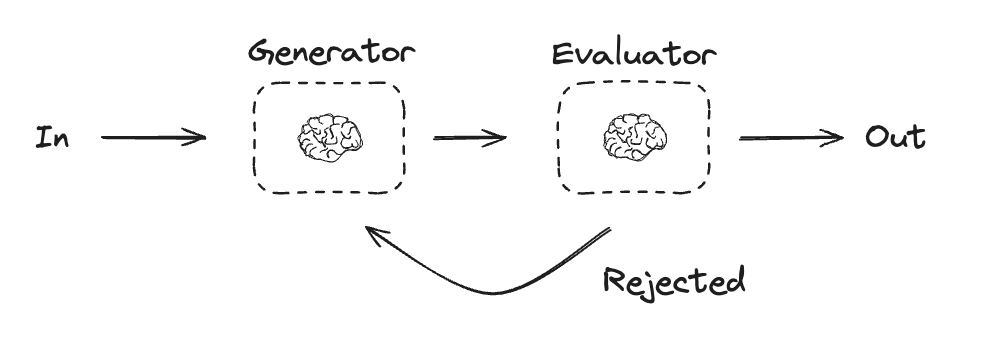
https://langchain-ai.github.io/langgraph/tutorials/workflows/img/evaluator_optimizer.png

## 代码逻辑
1. 创建状态图并编译实例，传入参数{"topic": "Cats"}
    - [State]：joke|topic编程Cat，调用时的第一步，修改状态|feedback|funny_or_not
    - 节点添加： 
        1. llm_call_generator
        2. llm_call_evaluator
    - 逻辑添加：
        - START -> "llm_call_generator" -> "llm_call_evaluator" -> END or llm_call_generator(with feedback)

2. 执行第一个节点：llm_call_generator；
    - [State]：joke-第一次joke内容|topic：Cats|feedback|funny_or_not，其他无变化
    - 逻辑 ： 判断当前state中的feedback是否有内容，如果有责调用大模型，根据模版和feedback新生成一个joke。如果没有内容，则调用大模型生成一个joke。结果是一个对象被赋值给msg了。
3. 执行第二个节点：llm_call_evaluator；
    - [State]：joke-第一次joke内容|topic：Cats|feedback-有数据了|funny_or_not-填入了新的数据
    - 逻辑 ： 调用结构化输出结果的大模型（当调用时，不仅会给到提示词本身，结构化输出的过程也是提示词的一部分，要求大模型按需求输出结果），得到一个Feedback类，包含评分和反馈描述，最后将这两部分内容整理成字典，LangGraph会自动更新到全局状态中。
4. 执行第三个节点 END or llm_call_generator Depends on [route_joke]；
    - [State]：joke-第一次joke内容|topic：Cats|feedback-有数据了|funny_or_not-填入了新的数据。 这里需要根据具体走了什么节点进一步判断。
    - 逻辑 ： evaluator已经判断了是否好笑，根据这个数据来进一步判断走哪个节点，好笑就返回接受并根据映射走结束节点，不好笑就返回拒绝+反馈，根据映射走生成节点。
    
5. 输出最终笑话内容

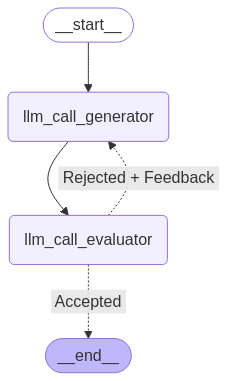

Sure! Here's a purr-fect cat joke for you:  

**Why don’t cats play poker in the wild?**  
*Because too many cheetahs!* 😹  

(Or if you prefer a classic one-liner: **"My cat just wrote a book on how to get what you want. It's called *The Meow-nipulation Handbook*."**)  

Let me know if you want more—I’ve got a *litter* of them! �🐾


In [16]:
# Graph state
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str


# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )


# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)


# Nodes
def llm_call_generator(state: State):
    """LLM generates a joke"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""

    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}


# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"


# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = optimizer_workflow.invoke({"topic": "Cats"})
print(state["joke"])

# 9.Agent
- 代理可以处理复杂的任务，但它们的实现往往很简单。它们通常只是基于环境反馈循环中使用工具的大型语言模型。因此，清晰且深思熟虑地设计工具集及其文档至关重要。
- 何时使用代理：代理适用于开放性问题，即难以或无法预测所需步骤数量，且无法硬编码固定路径的问题。在这种情况下，大型语言模型可能会运行多个回合，你必须对其决策能力有一定程度的信任。代理的自主性使其非常适合在可信环境中扩展任务。
- 图解：
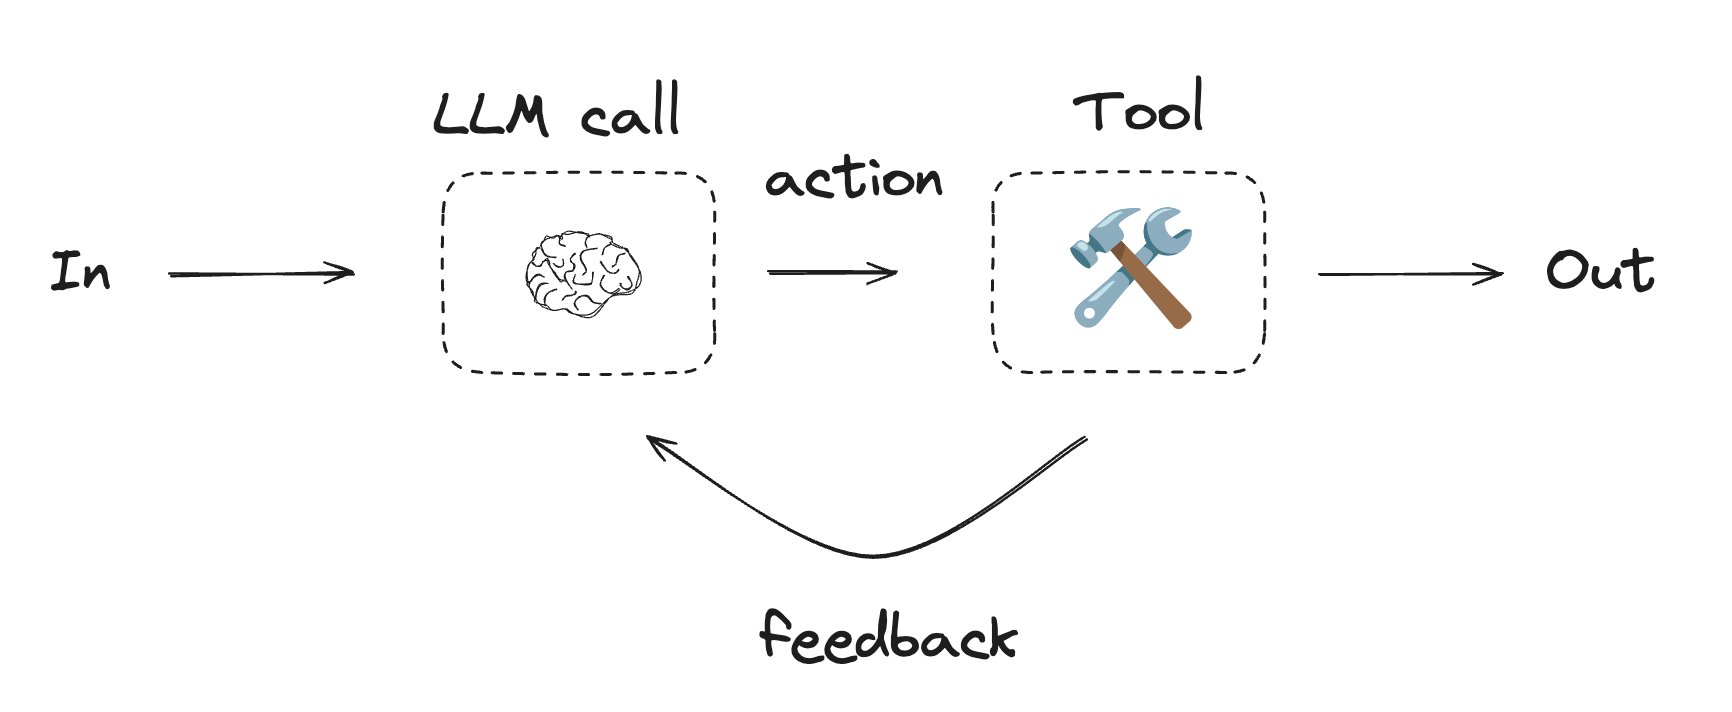
https://langchain-ai.github.io/langgraph/tutorials/workflows/img/agent.png

## 代码逻辑
- 创建工具集，创建状态图
- 输入初始提示词，调用状态图
- 运行第一个节点，将提示模版和提示词一起传给大模型并得到结果
- 判断是否有工具调用需求，如果有则调用相关工具，如果没有则结束
- 调用工具后，将工具结果返回到状态中，然后重新执行第一个节点，根据提示词模版、历史消息和新的到工具结果一起传给大模型，大模型会给到最终结果

* Langgraph有预创建的Agents模版可以使用

In [17]:
from langchain_core.tools import tool


# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

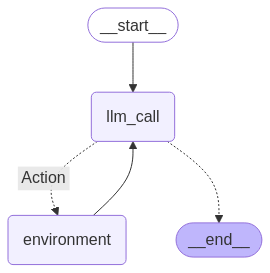

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_0_0e96d289-3c13-4463-babf-7c761377328f)
 Call ID: call_0_0e96d289-3c13-4463-babf-7c761377328f
  Args:
    a: 3
    b: 4
================================= Tool Message =================================

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


In [18]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage


# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ]
    }


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END


# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Invoke
messages = [HumanMessage(content="Add 3 and 4.")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

In [22]:
from langgraph.prebuilt import create_react_agent

# Pass in:
# (1) the augmented LLM with tools
# (2) the tools list (which is used to create the tool node)
pre_built_agent = create_react_agent(llm, tools=tools)

# Show the agent
# display(Image(pre_built_agent.get_graph().draw_mermaid_png()))

# Invoke
messages = [HumanMessage(content="Add 3 and 4.")]
messages = pre_built_agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_0_976db435-9876-4bac-a002-88a634ae0b82)
 Call ID: call_0_976db435-9876-4bac-a002-88a634ae0b82
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.
